In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [2]:
def us_age_distribution(path: str = "./data/age.csv") -> tuple[int, np.ndarray]:
    '''
    create array of integers that represent age distribution of US population.
    array will be used to plot kernel density estimation of US population's age
    '''
    census_age: pd.DataFrame = pd.read_csv(path)
    total_us_pop: int = sum(census_age.loc[:, "POP"])

    # scale down count to decrease number of data points in us_age_dist
    SCALE: int = 10000
    us_age_dist: pd.Series = np.repeat(census_age.loc[:, "AGE"], 
                                       census_age.loc[:, "POP"] / SCALE)

    return  total_us_pop, us_age_dist


def compare_age_distributions() -> None:
    '''
    produces plot that compares the age distribution of the entire US 
    populations and the age distribution of the casualities
    '''

    total_us_pop, us_age_dist = us_age_distribution()
    washpost_age_dist = pd.read_csv("./data/washpost.csv").loc[:, "age"].dropna()
    compare_age_distributions(total_us_pop, us_age_dist, washpost_age_dist)

    f, [ax_kde, ax_box] = plt.subplots(2, figsize = (10, 6), 
                                          sharex = True, 
                                          gridspec_kw = {"height_ratios":(0.85, 0.15)})

    washpost_color = "#0b84a5"
    census_color = "#f6c85f"

    ################################################
    ### EDITS TO KERNAL DENSITY ESTIMATION PLOTS ###
    ################################################

    # plot US population age distribution and cauality age distribution
    us_age_dist.plot.density(ax = ax_kde, linewidth = 3, color = census_color)
    washpost_age_dist.plot.density(ax = ax_kde, linewidth = 3, color = washpost_color,)

    # format x-axis of box plot
    ax_kde.set_xlabel("Years", fontsize = 14)
    ax_kde.set_xlim(-5, 100)

    # format ticks of kde plot
    ax_kde.get_yaxis().set_visible(False)
    ax_kde.tick_params(axis = 'x', length = 0)

    # remove border around kde plot
    ax_kde.spines["top"].set_visible(False)
    ax_kde.spines["right"].set_visible(False)
    ax_kde.spines["left"].set_visible(False)

    #########################
    ### EDITS TO BOX PLOT ###
    #########################

    # create box plot
    bp = ax_box.boxplot(washpost_age_dist.values, 
                        vert = False, 
                        showmeans = False, 
                        patch_artist = True, 
                        widths = 0.8, 
                        whis = 3)

    # color in box of boxplot
    plt.setp(bp["medians"], alpha = 0)
    for patch in bp["boxes"]:
        patch.set(facecolor = washpost_color, alpha = .9)

    # format ticks of box plot
    ax_box.tick_params(size = 0, labelsize = 12, pad = 12)
    ax_box.xaxis.tick_top()
    ax_box.get_yaxis().set_visible(False)

    # remove border around box plot
    [ax_box.spines[s].set_visible(False) for s in ax_box.spines]

    # calculate minimum, lower quartile, upper quartile, and maximum of box plot
    [mi, p25, p75, ma] = np.quantile(washpost_age_dist.values, [0, 0.25, 0.75, 1]).astype(int)

    # label minimum, lower quartile, upper quartile, and maximum of box plot
    ax_box.text(ma + 1.5, 1, str(ma), fontsize = 16, ha = "left", va = "center")
    ax_box.text(mi - 1.5, 1, str(mi), fontsize = 16, ha = "right", va = "center")
    ax_box.text(p25, .3, str(p25), fontsize = 16, ha = "center", va = "center")
    ax_box.text(p75, .3, str(p75), fontsize = 16, ha = "center", va = "center")

    # label mean of box plot
    x = p75 - (p75 - p25) / 2
    m = round(np.mean(washpost_age_dist.values), 2)
    ax_box.text(x, 1, "$\mu = $" + str(m), fontsize = 16, ha = "center", va = "center", color = "white")

    #############################
    ### GENERAL EDITS TO PLOT ###
    #############################

    # add title
    ax_kde.text(43, .03, "Comparing Age Distributions (Years)", fontsize = 16)

    # calculate size of each popuatlation
    num_c = '{:,}'.format(len(washpost_age_dist.values))
    num_us = '{:,}'.format(total_us_pop)

    # create legend
    washpost_patch = mpatches.Patch(color = washpost_color, label = "Washington Post (n = " + num_c + ")")
    census_patch = mpatches.Patch(color = census_color, label = "US (n = " + num_us + ")")
    ax_kde.legend(handles = [washpost_patch, census_patch], 
                  prop = {"size": 12}, 
                  frameon = False, 
                  bbox_to_anchor = (.485, 0.87))

    plt.show()

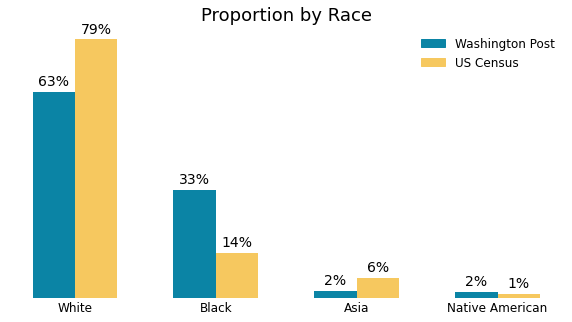

In [3]:
def compare_race_proportion():

    race = pd.read_csv("./data/race.csv").query("RACE > 0 and RACE < 5")
    washpost = pd.read_csv("./data/washpost.csv").query("race != 'H' and race != 'O'")

    map = pd.DataFrame({'lables_key'  : ["White", "Black", "Asia", "Native American"],
                        'washpost_key': ['W',     'B',     'A',    'N'],
                        'census_key'  : [ 1,       2,       4,      3 ]})

    washpost_df = (pd.DataFrame(washpost.loc[:, "race"].value_counts() / washpost.loc[:, "race"].dropna().size)
                     .rename(columns={"race": "washpost_race"}))
    census_df = (pd.DataFrame(race.loc[:, "POP"] / race.loc[:, "POP"].sum())
                   .rename(columns={"POP": "census_race"}))

    data = map.join(washpost_df, on = "washpost_key").join(census_df, on = "census_key")

    washpost_color = "#0b84a5"
    census_color = "#f6c85f"

    plt.figure(figsize = (10, 5))

    WIDTH = .6
    labels = data.loc[:, "lables_key"]
    x = np.linspace(0, 6, len(labels), dtype = int)

    plt.bar(x - WIDTH / 2, data.loc[:, "washpost_race"], WIDTH, color = washpost_color)
    plt.bar(x + WIDTH / 2, data.loc[:, "census_race"], WIDTH, color = census_color)
    plt.xticks(x, labels, fontsize = 12)

    # get current axis
    ax = plt.gca()

    # add title
    plt.title("Proportion by Race", fontsize = 18)

    # create legend
    washpost_patch = mpatches.Patch(color = washpost_color, label = "Washington Post")
    census_patch = mpatches.Patch(color = census_color, label = "US Census")
    ax.legend(handles = [washpost_patch, census_patch], prop = {"size": 12}, frameon = False,)

    # add measurment above bar
    for index, value in enumerate(x):
        plt.text(value - WIDTH / 2, data.loc[index, "washpost_race"] + .02, 
                                    "{:.0%}".format(data.loc[index, "washpost_race"]), 
                                    horizontalalignment = 'center', 
                                    fontsize = 14)

        plt.text(value + WIDTH / 2, data.loc[index, "census_race"] + .02, 
                                    "{:.0%}".format(data.loc[index, "census_race"]), 
                                    horizontalalignment = 'center', 
                                    fontsize = 14)

    # remove border around bar plot
    [ax.spines[s].set_visible(False) for s in ax.spines]

    # format ticks of kde plot
    ax.tick_params(axis = 'x', length = 0)
    ax.get_yaxis().set_visible(False)

    plt.show()

compare_race_proportion()